In [74]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
import matplotlib.gridspec as gridspec
from math import isnan
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# lets check for null and nan values
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


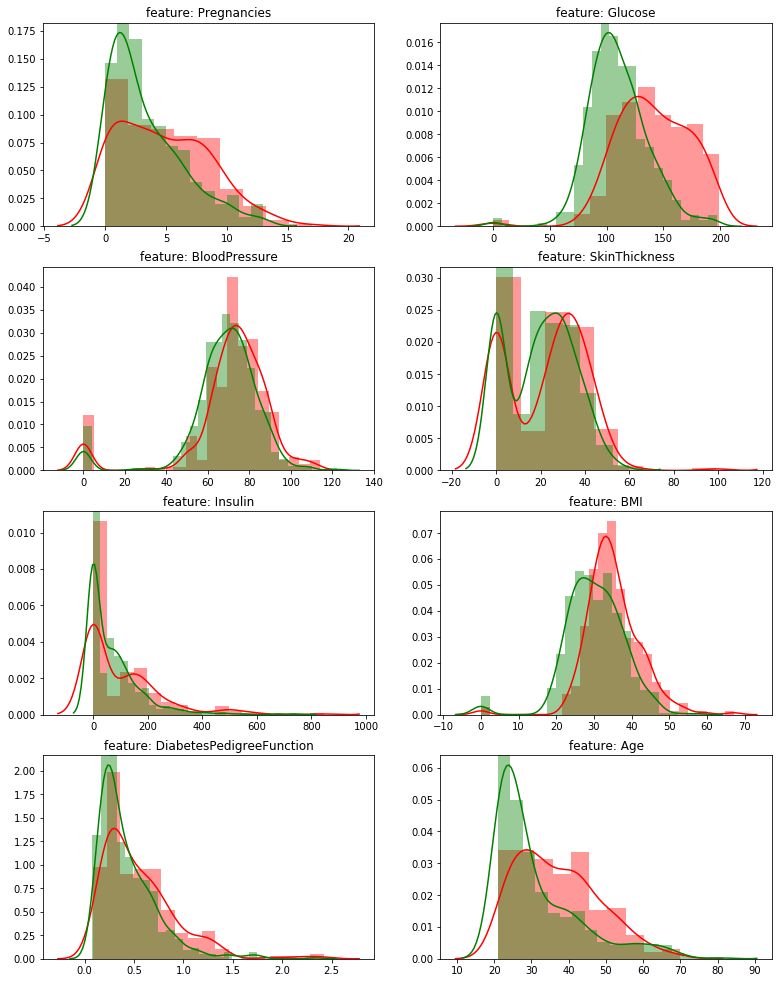

In [47]:
# lets get a sense of the values from a box plot after scaling
df2 = df.copy()
fig, ax = plt.subplots(4,2,figsize=(15,10))
for index,feature in enumerate(df2.columns[:-1]):
    row = index // 2
    col = index % 2
    ax5 = ax[row][col]
#     sns.distplot(df2[feature],ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 1], color='r',ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 0], color='g',ax=ax5)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(feature))
plt.subplots_adjust(bottom=0, right=0.8, top=1.3)
plt.show()

Text(0,0.5,'')

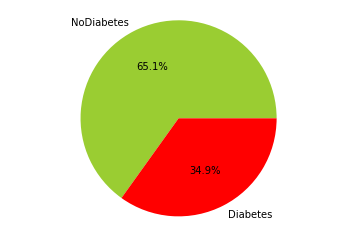

In [48]:
# lots of zero values that dont make sense. Also many of the features are skewed and not very gaussian.
# Check Outcome variable that has 0 value for no diabetes and 1 for diabetes
df2 = df.copy()
fig, ax = plt.subplots(1, 1)
ax.pie(df2.Outcome.value_counts(),autopct='%1.1f%%', labels=['NoDiabetes','Diabetes'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

We can see a clear bias here in the dataset towards people not having diabetes

In [49]:
# taking a closer look as Insulin
sorted(df2['Insulin'].unique())

[0,
 14,
 15,
 16,
 18,
 22,
 23,
 25,
 29,
 32,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 99,
 100,
 105,
 106,
 108,
 110,
 112,
 114,
 115,
 116,
 119,
 120,
 122,
 125,
 126,
 127,
 128,
 129,
 130,
 132,
 135,
 140,
 142,
 144,
 145,
 146,
 148,
 150,
 152,
 155,
 156,
 158,
 159,
 160,
 165,
 166,
 167,
 168,
 170,
 171,
 175,
 176,
 178,
 180,
 182,
 183,
 184,
 185,
 188,
 190,
 191,
 192,
 193,
 194,
 196,
 200,
 204,
 205,
 207,
 210,
 215,
 220,
 225,
 228,
 230,
 231,
 235,
 237,
 240,
 245,
 249,
 250,
 255,
 258,
 265,
 270,
 271,
 272,
 274,
 275,
 277,
 278,
 280,
 284,
 285,
 291,
 293,
 300,
 304,
 310,
 318,
 321,
 325,
 326,
 328,
 330,
 335,
 342,
 360,
 370,
 375,
 387,
 392,
 402,
 415,
 440,
 465,
 474,
 478,
 480,
 485,
 495,
 510,

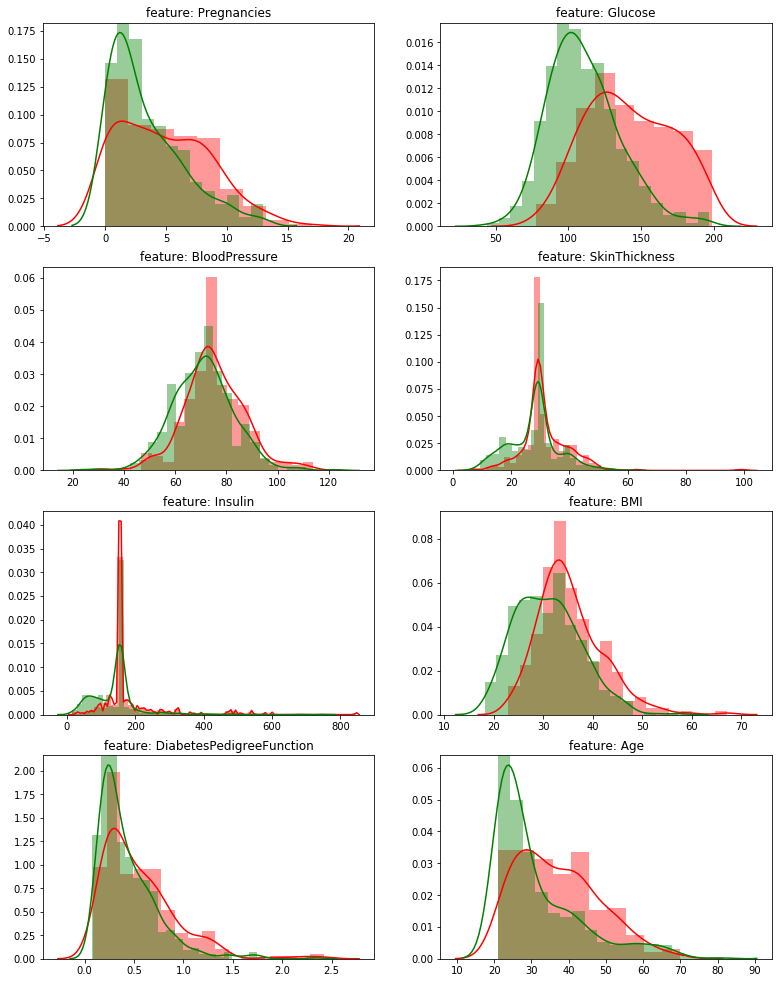

In [51]:
# So for Glucose, BloodPressure, SkinThickness and BMI lets replace the zero values by the mean value.
# We do so for insulin as well because 0 is not really possible
df2 = df.copy()
for feature in ['Glucose', 'BloodPressure', 'SkinThickness','BMI','Insulin']:
    df2[feature] = df2[feature].apply(lambda x : np.nan if x == 0.0 else x) # replace zeros by nan to not affect mean calc
    avg = np.mean(df2[feature])
    df2[feature] = df2[feature].apply(lambda x : avg if isnan(x) else x )
# now lets check the changes
fig, ax = plt.subplots(4,2,figsize=(15,10))
for index,feature in enumerate(df2.columns[:-1]):
    row = index // 2
    col = index % 2
    ax5 = ax[row][col]
#     sns.distplot(df2[feature],ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 1], color='r',ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 0], color='g',ax=ax5)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(feature))
plt.subplots_adjust(bottom=0, right=0.8, top=1.3)
plt.show()

This seems to make at least some sense now. Some of the features seem Gaussian like BMI and blood pressure but others dont.
Lets have a look again at both the two main NB classifiers Multinomial,Gaussian.

In [75]:
# create the testing dataset in an 80/20 split
df3 = shuffle(df2)
features =df2.columns[:-1]
feature_matrix = df2[features]
# .drop('Insulin')
X_train,X_test,y_train,y_test=train_test_split(feature_matrix,df2['Outcome'],random_state=1,test_size=0.2)

             precision    recall  f1-score   support

  NoDiabtes       0.69      0.80      0.74        99
   Diabetes       0.49      0.35      0.40        55

avg / total       0.62      0.64      0.62       154



0.6363636363636364

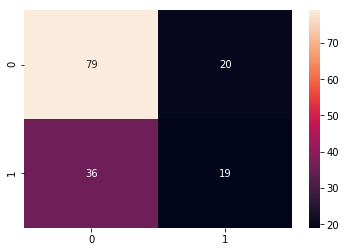

In [76]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train,y_train)
y_pred = MultiNB.predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
print(classification_report(y_test,y_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(y_test,y_pred)

             precision    recall  f1-score   support

  NoDiabtes       0.80      0.85      0.82        99
   Diabetes       0.69      0.62      0.65        55

avg / total       0.76      0.77      0.76       154



0.7662337662337663

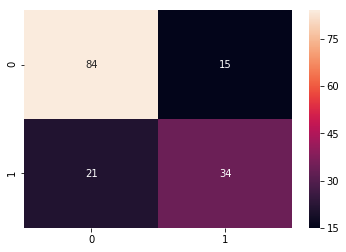

In [77]:
GaussNB = GaussianNB(priors=None)
GaussNB.fit(X_train,y_train)
y2_pred = GaussNB.predict(X_test)
sns.heatmap(confusion_matrix(y_test,y2_pred), annot=True)
print(classification_report(y_test,y2_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(y_test, y2_pred)

Ok so the Gaussian is a clear winner. The distribution of the features though are not very Gaussian like. Lets retry
the GaussianNB after standard scaler and have a look.

             precision    recall  f1-score   support

  NoDiabtes       0.80      0.85      0.82        99
   Diabetes       0.69      0.62      0.65        55

avg / total       0.76      0.77      0.76       154



0.7662337662337663

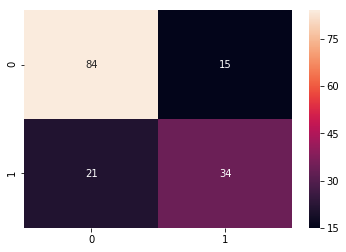

In [130]:
pipeline = Pipeline([('scaler', StandardScaler()),('clf', GaussianNB())])
pipeline.fit(X_train,y_train)
y3_pred = pipeline.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y3_pred), annot=True)
print(classification_report(y_test,y3_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(y_test, y3_pred)

So no difference really as we should expect since Naive bayes is not sensitive to scaling

             precision    recall  f1-score   support

  NoDiabtes       0.79      0.89      0.83        99
   Diabetes       0.74      0.56      0.64        55

avg / total       0.77      0.77      0.76       154



0.7727272727272727

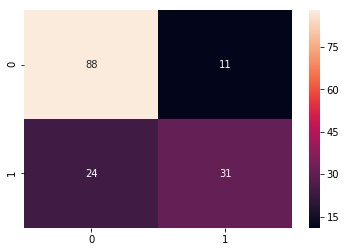

In [85]:
# So lets have a look at the Logistic Regression
pipeline2 = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression())])
pipeline2.fit(X_train,y_train)
y4_pred = pipeline2.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y4_pred), annot=True)
print(classification_report(y_test,y4_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(y_test, y4_pred)

Ok so very similar scores to the GaussianNB but Logistic Regression has a slight edge when it comes to the precision currently.
# What aspects of the data points do you believe contributed to the relative accuracy of these two classifiers?
It is clear from the pie chart that the Outcome classes are imbalanced. A more balanced Class structure should give better results.


# Which of the two classifiers do you believe to be better and under what circumstances?
Naive Bayes has a Theoretical Perfomance of O(log n) vs the O(n) of Logistic regression. Thus NB performs beter on large datasets provided conditional independance holds. NB also ignores Joint probabilites. Also with small datasets as this one, Logostic Regression can overfit. Also with some tweaking of the priors, less false negatives can be seen in NB

# If you used a Naive Bayes method provided by sklearn, what extra data preprocessing steps or modifications to the method itself could have yielded better performance?

As seen below, tweaking the priors for the GaussianNB gives slightly better results. But overall a better sampling of the predicted class in a 50/50 split should yield better results

             precision    recall  f1-score   support

  NoDiabtes       0.80      0.85      0.82        99
   Diabetes       0.69      0.62      0.65        55

avg / total       0.76      0.77      0.76       154



0.7727272727272727

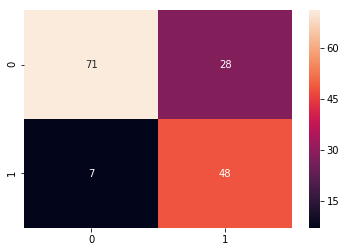

In [134]:
pipeline_nb = Pipeline([('clf', GaussianNB(priors=[0.349,0.651]))])
pipeline_nb.fit(X_train,y_train)
y5_pred = pipeline_nb.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y5_pred), annot=True)
print(classification_report(y_test,y3_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(y_test, y5_pred)

In [135]:
# lets make a dataframe with a more balanced set of outcomes
df.shape

(768, 9)

In [138]:
df[df.Outcome == 1].shape

(268, 9)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
482,4,85,58,22,49,27.8,0.306,28,0
528,0,117,66,31,188,30.8,0.493,22,0
80,3,113,44,13,0,22.4,0.140,22,0
105,1,126,56,29,152,28.7,0.801,21,0
733,2,106,56,27,165,29.0,0.426,22,0


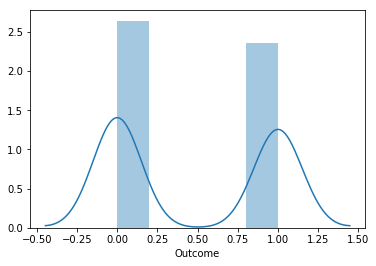

In [180]:
df_1 = df[df.Outcome == 1]
df_0 = df[df.Outcome == 0].sample(frac=0.6,random_state=1)
df_new = pd.concat((df_0,df_1))
sns.distplot(df_new['Outcome'])
df_new.head()

Text(0,0.5,'')

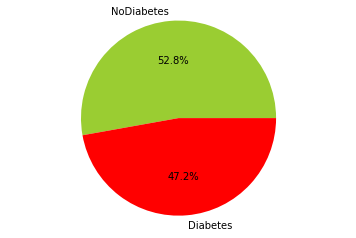

In [181]:
fig, ax = plt.subplots(1, 1)
ax.pie(df_new.Outcome.value_counts(),autopct='%1.1f%%', labels=['NoDiabetes','Diabetes'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

             precision    recall  f1-score   support

  NoDiabtes       0.72      0.89      0.80        53
   Diabetes       0.88      0.70      0.78        61

avg / total       0.81      0.79      0.79       114



0.7894736842105263

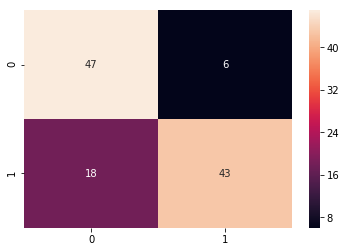

In [187]:
Xn_train,Xn_test,yn_train,yn_test=train_test_split(df_new[df_new.columns[:-1]],df_new['Outcome'],random_state=17,test_size=0.2)
pipeline_nb1 = Pipeline([('clf', GaussianNB())])
pipeline_nb1.fit(Xn_train,yn_train)
yn_pred = pipeline_nb1.predict(Xn_test)
sns.heatmap(confusion_matrix(yn_test, yn_pred), annot=True)
print(classification_report(yn_test,yn_pred,target_names=["NoDiabtes","Diabetes"]))
accuracy_score(yn_test, yn_pred)